# Praktyczny Machine Learning w Pythonie
<br>
<img src="figures/dilbert-2213.gif">

## Rozpoznawanie cyfr

Nasz model będzie składał się z 2 kroków:
1. Zmniejszenie ilości wymiarów
2. Klasyfikacja modelem liniowym

Najpierw jednak musimy zapoznać się ze zbiorem danych.

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

### MNIST

<img src="figures/mnist_originals.png">

MNIST to baza danych odręcznie napisanych cyfr około 20 lat temu. Ludzie są w stanie rozpoznać ok. 99,5% cyfr z tego zbioru poprawnie.
Zobaczymy ile nam się uda!

In [3]:
img = mnist.data[0]
print "Pierwsz obrazek z ", mnist.data.shape[0], ":", img # Pixele

Pierwsz obrazek z  70000 : [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 163 252 252 252 253

/Users/kudkudak/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


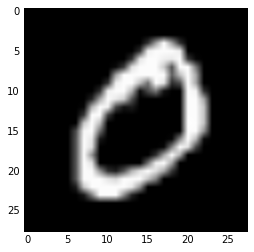

In [4]:
# Możemy sobie narysować wcześniej wypisaną cyfrę
import matplotlib.pylab as plt
%matplotlib inline
plt.imshow(img.reshape(28,28), cmap="gray")

In [5]:
import sklearn
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import numpy as np

### Krok 1: wczytanie i podzielenie danych

Skalowanie jest bardzo ważne. Dzięki temu mamy średnią danej cechy 0 i wariancję 1 (mówiąc po ludzku, dane będą bardziej  przypominały kulke w przestrzeni wejściowej)

<img src="figures/prepro2.jpeg" width=600>

In [6]:
#Wczytujemy dane i skalujemy
X, Y = mnist.data.astype("float64"), mnist.target 
X = preprocessing.scale(X)

Tak jak wspomniałem algorytm trenujemy na innych danych niż testujemy. **To bardzo ważne**. Do każdych danych da się dopasować taki model, który idealnie na nich odpowiada (np. poprzez zapamiętanie wszystkich przykładów). Jeśli tak zrobimy, to mówimy że nasz model **zoverfitował**.

<img src="figures/underfitting-overfitting.png">

In [7]:
#Dzielimy na dane trenujące i testujące
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

### Krok 2: dopasujmy pare modeli - uwaga! To juz trwa chwile, 70000 przykladow o 784 cechach kazdy.

In [9]:
# Na wszystkich przykladach osiaga 92% dokladnosci. 
N = 500 # Podzbiór danych
model = LogisticRegression() # Model z domyślnymi parametrami
model.fit(X_train[0:N], Y_train[0:N])

Y_test_predicted = model.predict(X_test)
print "Dokładność modelu wytrenowanego na ",N, " przykladach to: ",100*sklearn.metrics.accuracy_score(Y_test, Y_test_predicted), "%"

Dokładność modelu wytrenowanego na  500  przykladach to:  79.5828571429 %


In [10]:
Y_test[0]

3.0

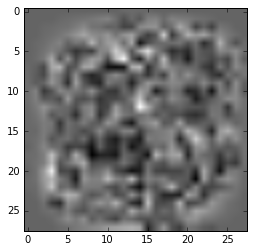

In [11]:
plt.imshow(model.coef_[3].reshape(28,28), cmap="gray")

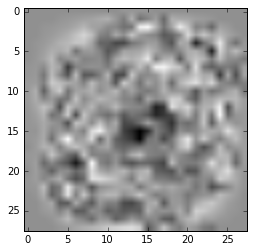

In [12]:
plt.imshow(model.coef_[0].reshape(28,28), cmap="gray")

Przyklad zaklasyfikowany jako  [ 3.]


/Users/kudkudak/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


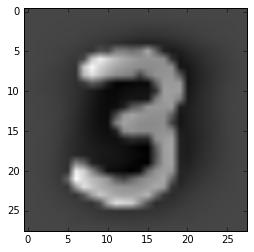

In [13]:
print "Przyklad zaklasyfikowany jako ", model.predict(X_test[0])
plt.imshow(X_test[0].reshape(28,28), cmap="gray")

### Krok 3: Tworzymy caly model zmniejszając ilość przykładów

W scikit-learn możemy połączyć pare modeli w **pipeline**, który sam implementuje interfejs **Estimator**.

In [14]:
pca = decomposition.PCA(n_components=20)
pca.fit(X_train)
X_train_transf = pca.transform(X_train)

In [15]:
logistic = linear_model.LogisticRegression(C=0.1)
logistic.fit(X_train_transf, Y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Pipeline pozwala spinać obiekty typu `Estimator`. Za pomocą pipeline można tworzyć bardzo skomplikowane modele, które mają bardzo prosty interfejs

In [16]:
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [17]:
#Zobaczmy na dokładność modelu
Y_test_predicted = pipe.predict(X_test)
print "Dokładność modelu wytrenowanego to: ",100*sklearn.metrics.accuracy_score(Y_test, Y_test_predicted), "%"

Dokładność modelu wytrenowanego to:  85.1828571429 %


**Poprawa o 6%! Nice**

### Poszukajmy najlepszych hiperparametrów

In [16]:
from sklearn.grid_search import GridSearchCV

N = 200
tuned_parameters = [{'pca__n_components':[10,20,30], 'logistic__C':  [1, 10, 100, 1000]}]
clf_fitted = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
clf = GridSearchCV(clf_fitted, tuned_parameters, cv=5, scoring='accuracy', verbose=4)
clf.fit(X_train[0:N], Y_train[0:N])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] logistic__C=1, pca__n_components=10 .............................
[CV] .... logistic__C=1, pca__n_components=10, score=0.604651 -   0.0s
[CV] logistic__C=1, pca__n_components=10 .............................
[CV] .... logistic__C=1, pca__n_components=10, score=0.690476 -   0.0s
[CV] logistic__C=1, pca__n_components=10 .............................
[CV] .... logistic__C=1, pca__n_components=10, score=0.675000 -   0.0s
[CV] logistic__C=1, pca__n_components=10 .............................
[CV] .... logistic__C=1, pca__n_components=10, score=0.657895 -   0.0s
[CV] logistic__C=1, pca__n_components=10 .............................
[CV] .... logistic__C=1, pca__n_components=10, score=0.648649 -   0.1s
[CV] logistic__C=1, pca__n_components=20 .............................
[CV] .... logistic__C=1, pca__n_components=20, score=0.720930 -   0.1s
[CV] logistic__C=1, pca__n_components=20 .............................
[CV] .... logist

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  25 jobs       | elapsed:    1.5s



[CV] logistic__C=10, pca__n_components=30 ............................
[CV] ... logistic__C=10, pca__n_components=30, score=0.720930 -   0.1s
[CV] logistic__C=10, pca__n_components=30 ............................
[CV] ... logistic__C=10, pca__n_components=30, score=0.738095 -   0.1s
[CV] logistic__C=10, pca__n_components=30 ............................
[CV] ... logistic__C=10, pca__n_components=30, score=0.775000 -   0.1s
[CV] logistic__C=10, pca__n_components=30 ............................
[CV] ... logistic__C=10, pca__n_components=30, score=0.789474 -   0.1s
[CV] logistic__C=10, pca__n_components=30 ............................
[CV] ... logistic__C=10, pca__n_components=30, score=0.783784 -   0.1s
[CV] logistic__C=100, pca__n_components=10 ...........................
[CV] .. logistic__C=100, pca__n_components=10, score=0.697674 -   0.1s
[CV] logistic__C=100, pca__n_components=10 ...........................
[CV] .. logistic__C=100, pca__n_components=10, score=0.690476 -   0.1s
[CV] 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    4.9s finished


GridSearchCV(cv=5,
       estimator=Pipeline(steps=[('pca', PCA(copy=True, n_components=20, whiten=False)), ('logistic', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'logistic__C': [1, 10, 100, 1000], 'pca__n_components': [10, 20, 30]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=4)

In [17]:
clf.best_estimator_

Pipeline(steps=[('pca', PCA(copy=True, n_components=30, whiten=False)), ('logistic', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001))])

In [18]:
#Zobaczmy na dokładność modelu
Y_test_predicted = clf.best_estimator_.predict(X_test)
print "Dokładność modelu wytrenowanego to: ",100*sklearn.metrics.accuracy_score(Y_test, Y_test_predicted), "%"

Dokładność modelu wytrenowanego to:  75.9085714286 %


Dokładność jest mniejsza, ponieważ ograniczyliśmy sztucznie ilość przykładów. Spróbuj ją zwiększyć

Dokładność modelu wytrenowanego to:  85.7142857143 %


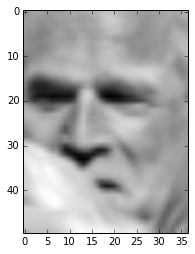

In [19]:
from sklearn.datasets import fetch_lfw_people

# Wczytanie danych i rozmiarow
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape

# Podzial na zbior trenujacy i testujacy
X = lfw_people.data
Y = lfw_people.target
X = preprocessing.scale(X.astype("float64")) #scale() to preprocessing który normalizuje dane ze sa symetrycznie wokol 0
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)


plt.imshow(X_train[2].reshape(h,w), cmap=plt.cm.gray)
logistic = linear_model.LogisticRegression(C=1)
logistic.fit(X_train, Y_train)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
Y_test_predicted = logistic.predict(X_test)
print "Dokładność modelu wytrenowanego to: ",100*sklearn.metrics.accuracy_score(Y_test, Y_test_predicted), "%"

In [20]:
n_samples, h, w

(1288, 50, 37)

In [8]:
## TODO: Dodatkowa sekcja?

# Konkurs

Wczytać i analogicznie jak poprzednio zbudować najlepszy model do zbioru danych faces z scikit-learn

<img src="figures/faces.png">

Podpowiedzi:

0. Warto pamiętać o skalowaniu danych
1. Jest to stosunkowo mały zbiór - prosty model nie będzie potrzebował PCA
2. Znaleźć najlepsze hiperparametry (tylko 1 w LogisticRegression)
3. Spróbować innego modelu (traktując go jako czarne pudełko z funkcja fit i predict :) ).
    * np. SVC z kernel="rbf" (ma 2 hiperparametry C, gamma)
4. Jeśli dobieramy 2 hiperparametry warto użyc GridSearch (samo szuka najlepszy zestaw parametrów) np. http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV 
5. Jeśli używamy bardziej skomplikowanego modelu (np. wspomnianego SVC) to należy użyć PCA (**lub innej techniki redukcji wymiarów**, PCA jest bardzo prostym modelem, zobaczyć `na sklearn.demposition`)